# Assignment 4: Chess Data Exploration


# 1 Region and Domain
Region: Dubai & Astana

Domain: Sports Analytics (Chess)

# 2 Research Question
I will be diving into the data from the 2021 and 2023 Chess World Championship and visualizing the trends of the strength of each chess move given the amount of time the players spent before each decision.

This exploration is primarily driven by some questions following the exciting 2023 FIDE World Chess Championship in Astana, Kazakhstan, this April, featuring Ding Liren from China and Ian Nepomniachtchi from Russia. The back-and-forth match concluded after 18 games. The Chinese Grandmaster ultimately emerged victorious after claiming his first-ever lead in the contest and defeating his nemesis with the black pieces for the first time that month. Of the 18 battles, 14 were "Classical" chess games, allotting each player three hours or more throughout the game to think about their move, and 4 were "Rapid" tiebreak playoff games, where contestants only had about 30 minutes each.

The goal in chess is to checkmate the opponent's king, trapping it so it cannot escape capture. Each player has different pieces with specific movement patterns. The chess clock is used to track the time each player spends on their moves, adding a strategic element and a sense of urgency to the game. Each game ends with the black pieces winning, white winning, or a draw, with the winner getting a point added to his match point total; in case of a draw, the point is evenly split. Not including tiebreaks, the match consists of 14 games, so the first to 7.5 points would win; ultimately, the 'Classical' (slow chess) portion of the match was drawn, and Ding Liren (Ding) defeated Ian Nepomniachtchi (Nepo) in the 4-game "Rapid" tiebreaks 2.5-1.5 when his victory in the fourth playoff game clinched him the title.

Throughout the match, Nepo exhibited his tendency to make impulsive moves, and while his intuition and quick calculation often put his opponents under tremendous pressure and thus make mistakes, sometimes it backfires, and his swift and uncareful play lands him in worse positions. On the other hand, his opponent often exhausted vast portions of his allotted time early on in the game and, as a result, made a few uncharacteristic blunders when the seconds started ticking low. Their contrasting styles beg the question, what is the relationship between time expenditure and move quality? This is the primary question that this data exploration sets out to answer. However, I understand that the games' sample size must be increased to draw conclusions. Nonetheless, it's nice to start our analytical journey on a dataset with the least amount of external noise. So, off we go to Astana with Nepo and Ding!

Luckily, just two years prior to Nepo's bid for the title, he faced off against then reigning champion Magnus Carlsen in the 2021 FIDE World Championships, where he also made memorable blunders. We will look at both sets of data and see if we can draw any conclusions.

# 3 Links

I will be using chess games data organized by https://lichess.org. Lichess is a free and open-source online chess platform that provides players with a user-friendly interface and various features for playing, learning, and analyzing chess games. It also streams and stores game data of lots of chess events, which is available at the broadcast tab.

https://lichess.org/broadcast

### Instructions for downloading [Chess Data](https://lichess.org/broadcast/fide-world-chess-championship-2023/round-9/FgD0ZXaV):
- Follow the first link below to the lichess page, click on the '1 Game' tab in any round or any board to display the game. 
- Click the "Share and Export" tab under the chessboard, and finally click "Download all Rounds" to get your chess 'pgn' file. (Basically a text file that follows a chess-data format)
- Lichess also has a well documented api that you can play with. It has lots of features to make this process even more automated.
- Lichess Broadcast manual download / Lichess api:
https://lichess.org/api#tag/Broadcasts

#### 2023 Dataset
https://lichess.org/broadcast/fide-world-chess-championship-2023/round-9/FgD0ZXaV
#### 2021 Dataset
https://lichess.org/broadcast/world-chess-championship-2021/game-1/olFFWcs6


### Import Libraries
The following libraries will be used for data cleaning and visualizations

In [1]:
import pandas as pd
import re
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

### What is a PGN file?

Let's take a quick look at the contents of a pgn file:

In [2]:
#let's see if we're in the right directory
file_path = ['assets/LICHES~2.PGN', 'assets/LICHES~1.PGN']
contents = os.listdir()
if file_path[0] not in contents:
    try:
        os.chdir('/home/jovyan/work/assignments/course2_assignment4')
    except:
        print('Please move to the right directory that has the pgn file.')
    
with open(file_path[1], "r") as file:
    for line_number, line in enumerate(file, 1):
        print(line.strip())
        if line_number == 22:
            break

[Event "FIDE World Championship Match 2023"]
[Site "Astana KAZ"]
[Date "2023.04.09"]
[Round "1"]
[White "Nepomniachtchi, Ian"]
[Black "Liren, Ding"]
[Result "1/2-1/2"]
[WhiteElo "2795"]
[WhiteTitle "GM"]
[WhiteFideId "4168119"]
[BlackElo "2788"]
[BlackTitle "GM"]
[BlackFideId "8603677"]
[TimeControl "40/7200:20/3600:900+30"]
[UTCDate "2023.04.09"]
[UTCTime "10:24:03"]
[Variant "Standard"]
[ECO "C85"]
[Opening "Ruy Lopez: Closed, Delayed Exchange"]
[Annotator "https://lichess.org/@/loepare"]

1. e4 { [%eval 0.36] [%clk 1:59:53] } 1... e5 { [%eval 0.35] [%clk 1:59:11] } 2. Nf3 { [%eval 0.29] [%clk 1:59:46] } 2... Nc6 { [%eval 0.32] [%clk 1:58:51] } 3. Bb5 { [%eval 0.34] [%clk 1:59:40] } 3... a6 { [%eval 0.37] [%clk 1:58:17] } 4. Ba4 { [%eval 0.31] [%clk 1:59:34] } 4... Nf6 { [%eval 0.37] [%clk 1:57:52] } 5. O-O { [%eval 0.29] [%clk 1:59:07] } 5... Be7 { [%eval 0.36] [%clk 1:57:39] } 6. Bxc6 { [%eval 0.12] [%clk 1:58:42] } 6... dxc6 { [%eval 0.09] [%clk 1:57:19] } 7. Re1 { [%eval 0.0] [%c

Although it's a bit messy, there is some structure to this. Within the square brackets are metadata about this game, and then we have the move data for the game in this whole chunk of text. Take this for example:

1. e4 { [%eval 0.36] [%clk 1:59:53] }

That is move 1, the move (e4), the engine evaluation, and the timestamp. Let's organize this pgn file in a more readable and operable way.

In [3]:
#importing the dataset (pgn file)

def game_to_df(i):
    game_metadata = []
    raw_pgn_text = []

    with open(file_path[i]) as f:
        lines = f.readlines()
        newgame = True
        for line in lines:
            if newgame == True:
                newgame = False
                game_metadata_dict = {}
            if line[0] == '[':
                key = list(line[1:-3].split('"'))[0].strip()
                val = list(line[1:-3].split('"'))[1].strip()
                game_metadata_dict[key] = val
            if line[:2] == '1.':
                raw_pgn_text.append(line)
                game_metadata.append(game_metadata_dict)
                newgame = True

    #populate games_df
    games_df = pd.DataFrame(game_metadata)
    games_df['raw_pgn'] = raw_pgn_text

    #tiebreaks and index
    games_df['Round'] = games_df['Round'].astype(int)
    games_df.loc[14:, 'Round'] = [(14 + x) for x in games_df.loc[14:, 'Round']] #tiebreaks are round 15-18
    games_df = games_df.set_index('Round')

    #remove columns
    return games_df[['Event', 'Site', 'Date', 'White', 'Black', 'Result', 'ECO', 'Opening', 'raw_pgn']]
games_df_2021 = game_to_df(0)
games_df_2023 = game_to_df(1)
games_df = pd.concat([games_df_2021, games_df_2023], ignore_index=True)
games_df['TimeControl'] = ["40/7200:20/3600:900+30"]*25+["1500+10"]*4
games_df

,Event,Site,Date,White,Black,Result,ECO,Opening,raw_pgn,TimeControl
0,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.11.26,"Nepomniachtchi, Ian","Carlsen, Magnus",1/2-1/2,C88,Ruy Lopez: Closed,1. e4 { [%eval 0.23] [%clk 2:00:00] } 1... e5 ...,40/7200:20/3600:900+30
1,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.11.27,"Carlsen, Magnus","Nepomniachtchi, Ian",1/2-1/2,E06,Catalan Opening: Closed,1. d4 { [%eval 0.0] [%clk 1:59:57] } 1... Nf6 ...,40/7200:20/3600:900+30
2,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.11.28,"Nepomniachtchi, Ian","Carlsen, Magnus",1/2-1/2,C88,"Ruy Lopez: Closed, Anti-Marshall",1. e4 { [%eval 0.23] [%clk 1:59:53] } 1... e5 ...,40/7200:20/3600:900+30
3,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.11.30,"Carlsen, Magnus","Nepomniachtchi, Ian",1/2-1/2,C42,"Russian Game: Classical Attack, Staunton Varia...",1. e4 { [%eval 0.0] [%clk 1:59:57] } 1... e5 {...,40/7200:20/3600:900+30
4,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.01,Ian Nepomniachtchi,Magnus Carlsen,1/2-1/2,C88,"Ruy Lopez: Closed, Anti-Marshall",1. e4 { [%eval 0.2] [%clk 1:59:52] } 1... e5 {...,40/7200:20/3600:900+30
5,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.03,"Carlsen, Magnus","Nepomniachtchi, Ian",1-0,D02,"Queen's Pawn Game: Symmetrical Variation, Pseu...",1. d4 { [%eval 0.44] [%clk 1:59:57] } 1... Nf6...,40/7200:20/3600:900+30
6,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.04,"Nepomniachtchi, Ian","Carlsen, Magnus",1/2-1/2,C88,"Ruy Lopez: Closed, Anti-Marshall",1. e4 { [%eval 0.2] [%clk 2:00:00] } 1... e5 {...,40/7200:20/3600:900+30
7,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.05,Magnus Carlsen,Ian Nepomniachtchi,1-0,C43,"Russian Game: Modern Attack, Center Variation",1. e4 { [%eval 0.2] [%clk 2:00:00] } 1... e5 {...,40/7200:20/3600:900+30
8,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.07,Ian Nepomniachtchi,Magnus Carlsen,0-1,A13,English Opening: Agincourt Defense,1. c4 { [%eval 0.23] [%clk 2:00:00] } 1... e6 ...,40/7200:20/3600:900+30
9,FIDE World Championship 2021,"Dubai, United Arab Emirates",2021.12.08,Magnus Carlsen,Ian Nepomniachtchi,1/2-1/2,C42,Russian Game: Karklins-Martinovsky Variation,1. e4 { [%eval 0.2] [%clk 2:00:00] } 1... e5 {...,40/7200:20/3600:900+30


We've converted the pgn file to a dataframe. Although the information in the games_df don't seem too useful, there may be cases in the future where, instead of a match contested between two players, we have a tournament where everybody plays everybody, in that case, we might need to reference the metadata games_df when we're working with moves data, which is now all squeezed into the last row of games_df.

In [4]:
#converting raw pgn to df

pgns = games_df['raw_pgn']
cleaned_pgn_dfs = []

# Regular expressions to extract the desired information
pattern = r'(\d+)\.+ ([KQBNRa-h1-8Ox+-=]+)\s.*?\[%eval (.*?)\].*?\[%clk (.*?)\]'

for pgn in pgns:
    # Initialize lists to store extracted information
    move_num_list = []
    move_list = []
    eval_list = []
    clk_list = []

    # Extract information using regex
    matches = re.findall(pattern, pgn)
    for match in matches:
        move_num_list.append(match[0])
        move_list.append(match[1])
        eval_list.append(match[2])
        clk_list.append(match[3])

    # Create DataFrame
    data = {'Move_num': move_num_list,
            'Move': move_list,
            'Evaluation': eval_list,
            'Timestamp': clk_list}
    df = pd.DataFrame(data)
    cleaned_pgn_dfs.append(df)
cleaned_pgn_dfs[10].head() #sample

,Move_num,Move,Evaluation,Timestamp
0,1,e4,0.2,1:59:56
1,1,e5,0.12,1:59:40
2,2,Nf3,0.24,1:59:50
3,2,Nc6,0.12,1:59:33
4,3,Bc4,0.23,1:59:46


### Why Modify the Timestamp?
We've converted the last row of games_df into a list of dataframes called cleaned_pgn_dfs. Each item in this list is the entire game stored in a tabular form.

Note that we have an evaluation column and a timestamp column. Although it seems like simply plotting these columns against each other should suffice to answer our core question, the truth is a bit more complicated than that. There are problems with taking the numeric values of these two columns at face value, let's start with Timestamp first.

In chess, there's this confusing thing called time_control (you can refer to games_df['TimeControl']). The time control varies between tournaments, and are generally vastly different. One thing is for sure, they very rarely give you all the time you're allowed to think at the beginning of the game, and instead give you a portion of it, and withhold the rest until certain conditions are met. The additional times that are available is kind of like time-banks in poker, except you don't get to decide when you can use them, plus shot-clocks in basketball, and you may keep your extra seconds for the next offense if you didn't use up the shotclock this turn. The time control for this match, in the classical portion, is 120 minutes per side, with an 1 hour bonus on move 40, a further 30 hour bonus on move 60, and 30 extra seconds for each move made starting from move 60. The "Rapid" tiebreaks has a different time control: you start with 25 minutes, and you get ten extra seconds for every move you make. So, let's put these details in.

In [5]:
#handling time expenditure for each game
#TODO: parameterize constants

#figure out the time controls
time_control_dict = games_df['TimeControl'].value_counts().to_dict()
print(time_control_dict)

round_count = 0
for df in cleaned_pgn_dfs:
    df['Timestamp'] = pd.to_timedelta(df['Timestamp'])
    #Compute time spent on move considering time controls for classical
    time_spent = []
    increment = 1
    if round_count < 25: #classical games
        for i in range(len(df)):
            if i in [0,1]:
                diff = pd.Timedelta(seconds=7200) - df['Timestamp'].iloc[i]
                time_spent.append(diff)
            elif i in [78,79]:
                diff = df['Timestamp'].iloc[i-2] - df['Timestamp'].iloc[i]
                time_spent.append(diff + pd.Timedelta(seconds=3600))
            elif i >= 118:  
                diff = df['Timestamp'].iloc[i-2] - df['Timestamp'].iloc[i]
                if not increment < 0:
                    time_spent.append(diff + pd.Timedelta(seconds=930))
                    increment = increment - 1
                else:
                    time_spent.append(diff + pd.Timedelta(seconds=30))
            else:
                diff = df['Timestamp'].iloc[i-2] - df['Timestamp'].iloc[i]
                time_spent.append(diff)
        round_count += 1
        seconds_remaining_before_move = [7200,7200]
    else: #tiebreak games
        for i in range(len(df)):
            if i in [0,1]:
                diff = pd.Timedelta(seconds=1520) - df['Timestamp'].iloc[i]
                time_spent.append(diff)
            else:  
                diff = df['Timestamp'].iloc[i-2] - df['Timestamp'].iloc[i]
                time_spent.append(diff + pd.Timedelta(seconds=10))
        round_count += 1
        seconds_remaining_before_move = [1500,1500]
    #Add Time_spent and organize df
    df['Time_spent'] = time_spent
    df['Timestamp'] = df['Timestamp'].astype(str)
    df['Timestamp'] = [x.split()[2] for x in df['Timestamp']]
    df['Time_spent'] = df['Time_spent'].astype(str)
    df['Time_spent'] = [x.split()[2] for x in df['Time_spent']]
    df['Timestamp'] = df['Timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').strftime('%H:%M:%S'))
    df['Time_spent'] = df['Time_spent'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').strftime('%H:%M:%S'))
    
    def time_to_seconds(time_str):
        time_components = time_str.split(':')
        hours = int(time_components[0])
        minutes = int(time_components[1])
        seconds = int(time_components[2])
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    df['Seconds_spent'] = df['Time_spent'].apply(time_to_seconds)
    df['Seconds_remaining'] = df['Timestamp'].apply(time_to_seconds)
    df['Seconds_spent_by_opponent'] = df['Seconds_spent'].shift(1)
    df.loc[0,'Seconds_spent_by_opponent'] = 0
    df['Seconds_spent_by_opponent'] = df['Seconds_spent_by_opponent'].astype(int)
    
    seconds_remaining_before_move.extend(df['Seconds_remaining'][:-2].tolist())
    df['Seconds_remaining'] = seconds_remaining_before_move
    
cleaned_pgn_dfs[7].head() #sample

{'40/7200:20/3600:900+30': 25, '1500+10': 4}


,Move_num,Move,Evaluation,Timestamp,Time_spent,Seconds_spent,Seconds_remaining,Seconds_spent_by_opponent
0,1,e4,0.2,02:00:00,00:00:00,0,7200,0
1,1,e5,0.12,01:59:49,00:00:11,11,7200,0
2,2,Nf3,0.37,01:59:48,00:00:12,12,7200,11
3,2,Nf6,0.13,01:59:43,00:00:06,6,7189,12
4,3,d4,0.35,01:59:43,00:00:05,5,7188,6


### Why Modify the Evaluation?
Recall that interpreting 'Evaluation' at surface value is also a bit problematic. Traditionally, chess evaluation heavily relied on material count, where the value of each piece (pawn, knight, bishop, rook, queen) was assigned a numeric weight, and positions were evaluated based on the material balance between the two players. For instance, if a player had more valuable pieces than their opponent, the position would be considered better for them. This simplistic approach did not consider many other critical factors that influence a position's true strength, such as piece activity, pawn structure, king safety, control of key squares, and potential threats. However, modern chess engines evaluation function is based on deep knowledge of chess principles and patterns, combined with a vast number of position evaluations and game analysis. It uses advanced techniques like alpha-beta pruning, which allows it to efficiently search through millions of possible moves, simulating future positions and determining the best moves. As a result, the evaluation of a position in modern chess engines like Stockfish is far more accurate and comprehensive, going beyond the mere material count and considering the intricate dynamics of the position. In most cases, the strongest chess engines can form a highly accurate and sophiscated opinion on a position in mere seconds, far exceeding the capabilities of the strongest human players.

The numeric evaluations still carried over from the traditions of the past, with positive evaluation meaning advantage white and negative evaluations meaning advantage black. In high level play, we no longer say things like, "The evaluation of the position is +3, it's almost as if white is up 3 pawns, or a knight, I wonder who will win." Instead, a +1.5 advantage is already seen as objectively winning for the player in the lead, especially in a classical game where players can take the time to figure out their path to victory. If a player plays a move that shifts the evaluation from 0.00 (equal) to 2.00 (White is winning), it is seen as a losing blunder, but a move that shifts the engine evaluation from 9.00 to 11.00 is just another move, since it does not change the objective evaluation of the position at all. We'll be making adjustments to the "Evaluation" column to address this issue, and instead come up with a varaible that shows how a move impacted the expected point gained from this game (a loss awards 0 points, a draw 0.5, and a victory 1 point).

The next problem is that, although the strongest chess engines are very accurate in their assessment of a chess position, they still need time to calculate to come to the right conclusion, evaluations available in this pgn file is not ran by the strongest chess playing engines for minutes, so it's to be expected that they should be a bit off with their assessment, yet, in a game of such fine margins, this noise can throw a wrench in how much any conclusions regarding evaluation data can be trusted. Additionally, if I make a move that allows my opponent to checkmate me on the next turn while the position is equal, I just lost 0.5 points of expected result from this game, but if I made such a mistake while I was in a much better position say (+5.00), I would have lost nearly 1.00 points of expected value. However, it's hard to argue that one instance of allowing mate in one is a more serious mistake than the other, as both are irredeemably terrible moves. Therefore, I will also be grouping moves into ordinal categories in addition to assigning a numeric badness to each move.

In [6]:
#handling evaluation changes for each game
def get_eval_for_pos(evaluation):
    ranges = [1.5, 0.7, 0.26, -0.26, -0.7, -1.5]
    gamestate = list(range(-3, 4))[::-1]
    result = np.select(
        [evaluation > ranges[0], evaluation > ranges[1], evaluation > ranges[2], evaluation > ranges[3], evaluation > ranges[4], evaluation > ranges[5], evaluation <= ranges[5]],
        gamestate,
        default='Unknown'
    )
    return result

def override_first_two_move_eval(evaluation):
    first_four = evaluation[:4]
    first_four = [float(num) for num in first_four]
    mean = round((sum(first_four)/len(first_four)),2)
    evaluation[:4] = [mean]*4
    return evaluation

for df in cleaned_pgn_dfs:
    df['Evaluation'] = pd.Series(override_first_two_move_eval(list(df['Evaluation'])))
    df['Evaluation'] = df['Evaluation'].astype(str)
    eval_series = list(df['Evaluation'])
    eval_series_mod = []
    
    #replace forced mate evaluations with numeric
    for element in eval_series:
        if element.startswith('#'):
            if element.startswith('#-'):
                value = -100 / (math.log(float(element[2:])) + 0.1)
            else:
                value = 100 / (math.log(float(element[1:])) + 0.1)
            eval_series_mod.append(round(value, 2))
        else:
            eval_series_mod.append(float(element))
    
    #add column verbose_eval, numeric_eval, change_eval, gamestate to df  
    df['Gamestate'] = pd.Series(eval_series_mod).apply(get_eval_for_pos)
    verbose_eval_list = ['Black is Winning', 'Black is Clearly Better', 'Black is Slightly Better', 'Equal', 'White is Slightly Better', 'White is Clearly Better', 'White is Winning']
    gamestate_str_list = [str(x) for x in list(range(-3, 4))]
    mapping = dict(zip(gamestate_str_list, verbose_eval_list))
    df['Gamestate'] = df['Gamestate'].astype(str)
    df['Verbose_eval'] = df['Gamestate'].map(mapping)
    df['Gamestate'] = df['Gamestate'].astype(int)
    df['Change_gamestate'] = df['Gamestate'].diff()
    df.loc[0,'Change_gamestate'] = 0
    
    #add column numeric_eval, change_eval, and  to df  
    df['Numeric_eval'] = pd.Series(eval_series_mod)
    df['Change_eval'] = df['Numeric_eval'].diff()
    df.loc[0,'Change_eval'] = 0
    df['Centipawn_loss'] = df['Change_eval']*100  # Create a new column as a copy of the original column
    df['Centipawn_loss'][df.index % 2 == 0] *= -1  # Multiply the even-numbered rows by -1
    df['Centipawn_loss'] = df['Centipawn_loss'].astype(int)
    
    #add boolean column In_prep to indicate whether player is still in prep
    starttime = datetime.datetime.strptime(df.loc[0,'Timestamp'], "%H:%M:%S")
    startseconds = starttime.hour * 3600 + starttime.minute * 60 + starttime.second
    reasonable_recall_percentage = 0.04
    time_trouble_threshold = startseconds * 0.1
    in_prep_cutoff = startseconds * reasonable_recall_percentage
    df['In_time_trouble'] = df['Seconds_remaining'] < time_trouble_threshold
    
    movetimes = df['Seconds_spent']
    white_movetime = movetimes[movetimes.index % 2 == 0].reset_index(drop=True)
    black_movetime = movetimes[movetimes.index % 2 != 0].reset_index(drop=True)
    white_index = (white_movetime > in_prep_cutoff).idxmax()
    black_index = (black_movetime > in_prep_cutoff).idxmax()
    white_in_prep = [True]*white_index + [False]*(len(white_movetime) - white_index)
    black_in_prep = [True]*black_index + [False]*(len(black_movetime) - black_index)
    in_prep_bool = [val for pair in zip(white_in_prep, black_in_prep) for val in pair]
    df['In_prep'] = pd.Series(in_prep_bool)
cleaned_pgn_dfs[11].head() #sample

,Move_num,Move,Evaluation,Timestamp,Time_spent,Seconds_spent,Seconds_remaining,Seconds_spent_by_opponent,Gamestate,Verbose_eval,Change_gamestate,Numeric_eval,Change_eval,Centipawn_loss,In_time_trouble,In_prep
0,1,e4,0.33,01:59:53,00:00:07,7,7200,0,1,White is Slightly Better,0.0,0.33,0.00,0,False,True
1,1,e5,0.33,01:59:11,00:00:49,49,7200,7,1,White is Slightly Better,0.0,0.33,0.00,0,False,True
2,2,Nf3,0.33,01:59:46,00:00:07,7,7193,49,1,White is Slightly Better,0.0,0.33,0.00,0,False,True
3,2,Nc6,0.33,01:58:51,00:00:20,20,7151,7,1,White is Slightly Better,0.0,0.33,0.00,0,False,True
4,3,Bb5,0.34,01:59:40,00:00:06,6,7186,20,1,White is Slightly Better,0.0,0.34,0.01,-1,False,True


### What is 'Prep'?
You may notice that the last column in the previous dataframe is labeled "In_prep."

In chess, opening preparation involves strategically studying and memorizing specific move sequences, known as openings, that occur in the initial phase of a game. Players meticulously analyze and commit to memory well-established opening lines, ranging from traditional to cutting-edge, to gain an early advantage on the board. The goals of opening preparation include controlling key squares, developing pieces efficiently, safeguarding the king, and setting up potential attack or defense plans. By being well-prepared in the opening phase, players can navigate through the early complexities with confidence, create imbalances on the board, and potentially catch opponents off guard, ultimately aiming to set the tone for the middlegame and, eventually, the endgame.

Based on the amount of time players spend on their moves, we can hypothesize when they start to think independently, no longer relying solely on their memory. This introduces the premise of analyzing move quality and thinking time (not just the time it takes to remember their home-cooked analysis).

In [7]:
#handling evaluation changes for each move
game_index = 0
for df in cleaned_pgn_dfs:
    #Classify moves
    df.loc[:, 'Move_label'] = 3
    df.loc[(df['Centipawn_loss'] > 50) & (abs(df['Change_gamestate']) > 0), 'Move_label'] = 4
    df.loc[(df['Centipawn_loss'] > 75) & (abs(df['Change_gamestate']) > 1), 'Move_label'] = 5
    df.loc[(df['Centipawn_loss'] > 100) & (abs(df['Change_gamestate']) > 0), 'Move_label'] = 5
    df.loc[(df['Centipawn_loss'] > 150) & (abs(df['Change_gamestate']) > 2), 'Move_label'] = 6
    df.loc[(df['Centipawn_loss'] > 250) & (abs(df['Change_gamestate']) > 1), 'Move_label'] = 6
    df.loc[(df['Centipawn_loss'] < 25) & (abs(df['Change_gamestate']) == 0), 'Move_label'] = 2
    df.loc[(df['Centipawn_loss'] < -70) & (abs(df['Change_gamestate']) > 0), 'Move_label'] = 1
    
    #Add classification to df
    move_label_key = [str(x) for x in list(range(1,7))]
    move_label_list = ['Brilliant', 'Excellent', 'Good', 'Inaccuracy', 'Mistake', 'Blunder']
    mapping = dict(zip(move_label_key, move_label_list))
    df['Move_label'] = df['Move_label'].astype(str)
    df['Verbose_label'] = df['Move_label'].map(mapping)
    df['Move_label'] = df['Move_label'].astype(int)
        
    #add game number to df to prepare merging
    df['Game_num'] = game_index
    game_index = game_index + 1
    
cleaned_pgn_dfs[5].head() #sample

,Move_num,Move,Evaluation,Timestamp,Time_spent,Seconds_spent,Seconds_remaining,Seconds_spent_by_opponent,Gamestate,Verbose_eval,Change_gamestate,Numeric_eval,Change_eval,Centipawn_loss,In_time_trouble,In_prep,Move_label,Verbose_label,Game_num
0,1,d4,0.35,01:59:57,00:00:03,3,7200,0,1,White is Slightly Better,0.0,0.35,0.00,0,False,True,2,Excellent,5
1,1,Nf6,0.35,01:59:51,00:00:09,9,7200,3,1,White is Slightly Better,0.0,0.35,0.00,0,False,True,2,Excellent,5
2,2,Nf3,0.35,01:59:53,00:00:04,4,7197,9,1,White is Slightly Better,0.0,0.35,0.00,0,False,True,2,Excellent,5
3,2,d5,0.35,01:59:35,00:00:16,16,7191,4,1,White is Slightly Better,0.0,0.35,0.00,0,False,True,2,Excellent,5
4,3,g3,-0.09,01:59:45,00:00:08,8,7193,16,0,Equal,-1.0,-0.09,-0.44,43,False,True,3,Good,5


In [8]:
#let's also do expected game score 
def get_exp_score_for_pos(evaluation):
    ranges = np.arange(-2.25, 2.26, 0.5)
    exp_score = np.arange(0, 1.01, 0.1)
    if evaluation < ranges[0]:
        return exp_score[0]
    elif evaluation > ranges[9]:
        return exp_score[10]
    for i in range(len(ranges) - 1):
        if (evaluation > ranges[i]) & (evaluation <= ranges[i+1]):
            return round(exp_score[i+1],1)

for df in cleaned_pgn_dfs:
    df['Expected_game_score'] = pd.Series(df['Numeric_eval']).apply(get_exp_score_for_pos)
    df['Change_game_score'] = df['Expected_game_score'].diff()
    df.loc[0,'Change_game_score'] = 0
    df['Winrate_delta_for_move'] = df['Change_game_score']
    df['Winrate_delta_for_move'][df.index % 2 == 1] *= -1  # Multiply the odd-numbered rows by -1
cleaned_pgn_dfs[14].head()

,Move_num,Move,Evaluation,Timestamp,Time_spent,Seconds_spent,Seconds_remaining,Seconds_spent_by_opponent,Gamestate,Verbose_eval,...,Change_eval,Centipawn_loss,In_time_trouble,In_prep,Move_label,Verbose_label,Game_num,Expected_game_score,Change_game_score,Winrate_delta_for_move
0,1,c4,0.22,01:59:48,00:00:12,12,7200,0,0,Equal,...,0.00,0,False,True,2,Excellent,14,0.5,0.0,0.0
1,1,Nf6,0.22,01:59:53,00:00:07,7,7200,12,0,Equal,...,0.00,0,False,True,2,Excellent,14,0.5,0.0,-0.0
2,2,Nc3,0.22,01:58:58,00:00:50,50,7188,7,0,Equal,...,0.00,0,False,True,2,Excellent,14,0.5,0.0,0.0
3,2,e5,0.22,01:59:43,00:00:10,10,7193,50,0,Equal,...,0.00,0,False,True,2,Excellent,14,0.5,0.0,-0.0
4,3,Nf3,0.0,01:58:54,00:00:04,4,7138,10,0,Equal,...,-0.22,22,False,True,2,Excellent,14,0.5,0.0,0.0


### What is a Brilliant Move?
Chess engines, despite their remarkable strength and sophisticated algorithms, can still make mistakes in their assessments due to various reasons. Their search depth is limited by computational constraints, and they might overlook critical moves or strategies. Additionally, their evaluation functions, which approximate position strengths, can be imperfect, relying on heuristics that may not fully capture the complexities of a position. Moreover, chess engines can occasionally exhibit tactical blindness, missing deep or intricate tactical sequences. On the other hand, human players can surprise chess engines with brilliant moves that challenge their evaluations. Humans' creativity, intuition, and understanding of strategic ideas allow them to spot unconventional moves and exploit long-term plans that engines might not immediately recognize. Psychological factors, like introducing complications to unsettle opponents, can also lead engines to reassess positions differently. This blend of chess engines' computational power and human intuition makes modern chess an intriguing interplay between machine and human intelligence.

At lower search depths, the engine can be more prone to make evaluation errors, so when the human player plays a sophiscated move in a complicated position, the engine may initially not appreciate the strength of the move, or over-appreciate the strength of the move. For this analysis, the brilliant move label is awarded to a move that, upon being played, increased the engine's opinion of his position by quite a significant amount (the engine only realized how strong the move is after the human player showed it), but we also need to remove cases where the engine overreacts, otherwise every move is brilliant to a weak chess playing entity, although, there is some truth to the last statement.

In [9]:
#a bit of housekeeping 
for df in cleaned_pgn_dfs:
    for i in range(1, len(df)):
        if (df['Verbose_label'].iloc[i] == 'Brilliant' and df['Verbose_label'].iloc[i-1] == 'Brilliant'):
            eval_cols = ['Evaluation','Gamestate','Verbose_eval','Numeric_eval','Centipawn_loss','Expected_game_score','Winrate_delta_for_move']
            change_cols = ['Change_gamestate', 'Change_eval','Change_game_score','Move_label','Verbose_label']
            df.loc[(i-1),eval_cols] = df.loc[(i-2),eval_cols]
            df.loc[(i-1),change_cols] = [0,0,0,2,'Excellent']
            print('Fake Brilliancy')
            print(df.loc[i-1,['Game_num','Move_num','Move']])

Fake Brilliancy
Game_num    16
Move_num    41
Move        a2
Name: 81, dtype: object
Fake Brilliancy
Game_num    25
Move_num    24
Move        e4
Name: 46, dtype: object


### Move Time to Expected Value
Another way to understand expected value from game is the winning percentage, however, since there are also draws in chess, expected value or expected points is the more accurate term. We can see that, for most of the moves in each game, regardless of how long the players spent thinking, they don't deviate from the center (does not change evaluation of position).

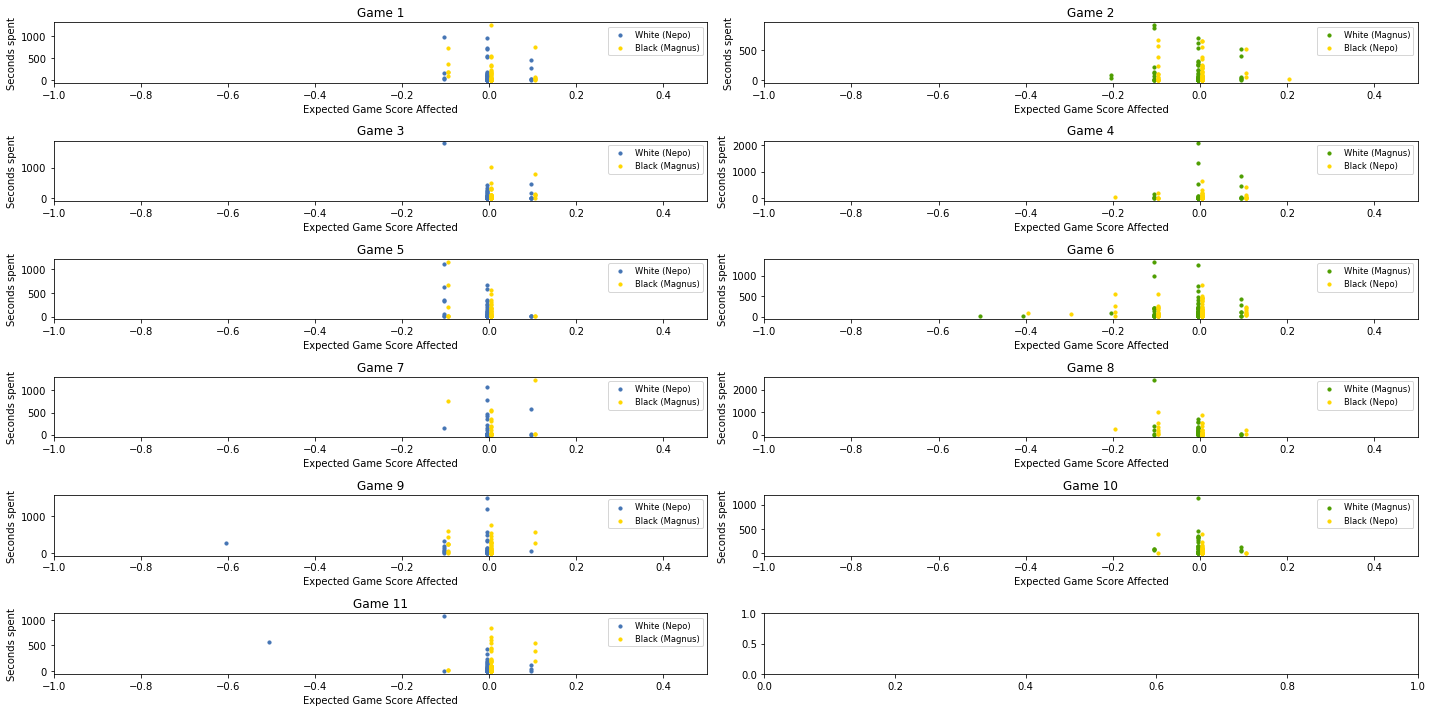

In [10]:
df_list = cleaned_pgn_dfs[:11] #Let's just look at 2023 Data for now

#let's name our players
Challenger = "Nepomniachtchi, Ian" #bad practice, I know
Defender = "Carlsen, Magnus" #bad practice, I know
challenger = Challenger[:4]
defender = Defender[-6:]

df_odd_list = []   # List to store DataFrames with odd-numbered rows
df_even_list = []  # List to store DataFrames with even-numbered rows

for df in df_list:
    # Split DataFrame into odd and even DataFrames
    df_odd = df.iloc[1::2]  # Select odd-numbered rows
    df_even = df.iloc[::2]  # Select even-numbered rows
    
    if len(df_odd) < len(df_even):
        df_odd = df_odd.append(pd.Series([3]), ignore_index=True)
    elif len(df_even) < len(df_odd):
        df_even = df_even.append(pd.Series([3]), ignore_index=True)
    
    df_odd_list.append(df_odd)
    df_even_list.append(df_even)

# Create subplots with a 6x3 layout
fig, axs = plt.subplots(6, 2, figsize=(20, 10))

# Flatten the axs array to iterate over each subplot
axs = axs.flatten()

# Plot 'Seconds_spent' column for each game as scatter plots
for i, (df_odd, df_even) in enumerate(zip(df_odd_list, df_even_list)):
    ax = axs[i]  # Select subplot for current game

    # Rest of the code remains the same

# Plot 'Time_spent' column for each game as scatter plots
for i, (df_odd, df_even) in enumerate(zip(df_odd_list, df_even_list)):
    ax = axs[i]  # Select subplot for current game
    
    if i % 2 == 0:
        ax.scatter(df_even['Winrate_delta_for_move']-0.005, df_even['Seconds_spent'], color='#4575b4', label='White ({})'.format(challenger), s=10)
        ax.scatter(df_odd['Winrate_delta_for_move']+0.005, df_odd['Seconds_spent'], color='#ffd700', label='Black ({})'.format(defender), s=10)
    else:
        ax.scatter(df_even['Winrate_delta_for_move']-0.005, df_even['Seconds_spent'], color='#4e9e00', label='White ({})'.format(defender), s=10)
        ax.scatter(df_odd['Winrate_delta_for_move']+0.005, df_odd['Seconds_spent'], color='#ffd700', label='Black ({})'.format(challenger), s=10)

    ax.set_xlabel('Expected Game Score Affected')
    ax.set_ylabel('Seconds spent')
    ax.set_title('Game {}'.format(i+1))
    ax.legend(loc='upper right', fontsize='small')
    ax.set_xlim(-1.0, 0.5)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


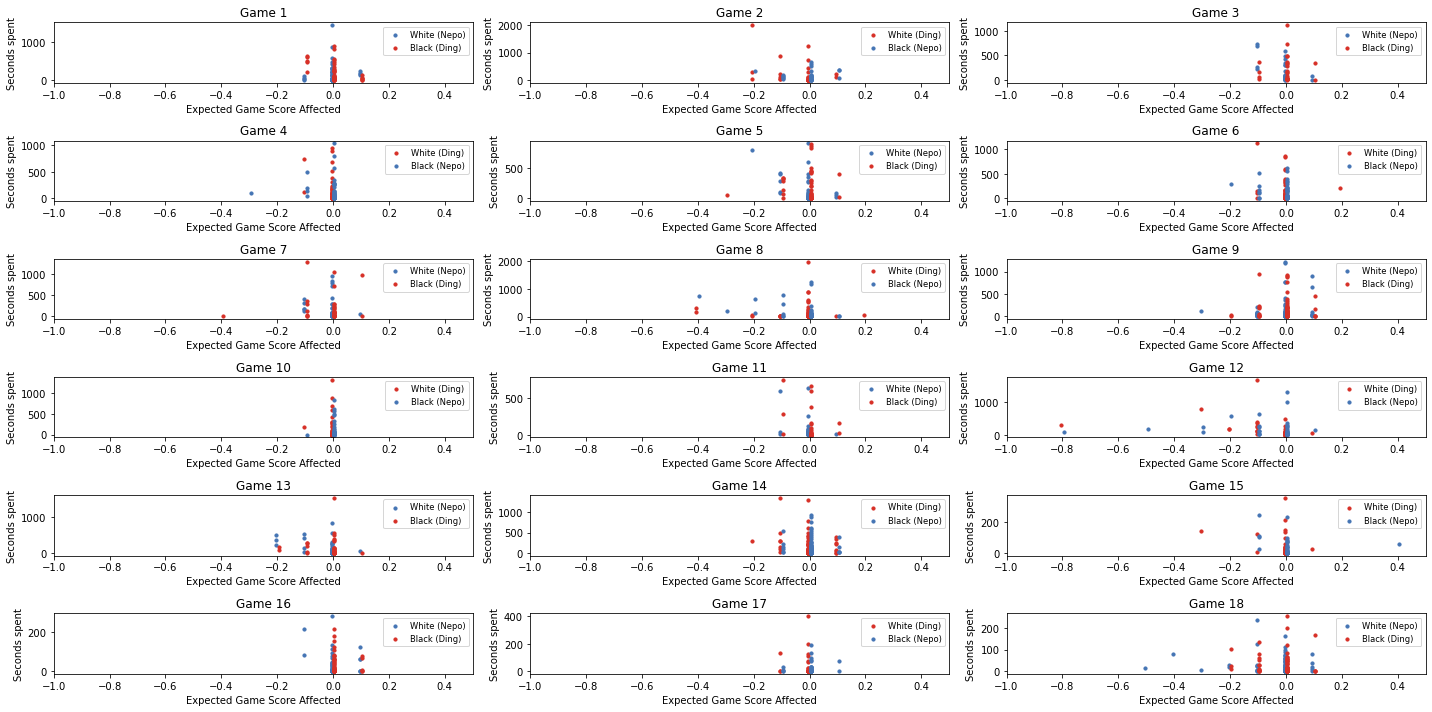

In [11]:
df_list = cleaned_pgn_dfs[11:] #Let's just look at 2023 Data for now

#let's name our players
Challenger = "Ding, Liren"
Defender = "Nepomniachtchi, Ian"
challenger = Challenger[:4]
defender = Defender[:4]

df_odd_list = []   # List to store DataFrames with odd-numbered rows
df_even_list = []  # List to store DataFrames with even-numbered rows

for df in df_list:
    # Split DataFrame into odd and even DataFrames
    df_odd = df.iloc[1::2]  # Select odd-numbered rows
    df_even = df.iloc[::2]  # Select even-numbered rows
    
    if len(df_odd) < len(df_even):
        df_odd = df_odd.append(pd.Series([3]), ignore_index=True)
    elif len(df_even) < len(df_odd):
        df_even = df_even.append(pd.Series([3]), ignore_index=True)
    
    df_odd_list.append(df_odd)
    df_even_list.append(df_even)

# Create subplots with a 6x3 layout
fig, axs = plt.subplots(6, 3, figsize=(20, 10))

# Flatten the axs array to iterate over each subplot
axs = axs.flatten()

# Plot 'Seconds_spent' column for each game as scatter plots
for i, (df_odd, df_even) in enumerate(zip(df_odd_list, df_even_list)):
    ax = axs[i]  # Select subplot for current game

    # Rest of the code remains the same

# Plot 'Time_spent' column for each game as scatter plots
for i, (df_odd, df_even) in enumerate(zip(df_odd_list, df_even_list)):
    ax = axs[i]  # Select subplot for current game
    
    if (i % 2 == 0 and not i >= 14) or (i % 2 != 0 and i >= 14):
        ax.scatter(df_even['Winrate_delta_for_move']-0.005, df_even['Seconds_spent'], color='#4575b4', label='White ({})'.format(defender), s=10)
        ax.scatter(df_odd['Winrate_delta_for_move']+0.005, df_odd['Seconds_spent'], color='#d73027', label='Black ({})'.format(challenger), s=10)
    else:
        ax.scatter(df_even['Winrate_delta_for_move']-0.005, df_even['Seconds_spent'], color='#d73027', label='White ({})'.format(challenger), s=10)
        ax.scatter(df_odd['Winrate_delta_for_move']+0.005, df_odd['Seconds_spent'], color='#4575b4', label='Black ({})'.format(defender), s=10)

    ax.set_xlabel('Expected Game Score Affected')
    ax.set_ylabel('Seconds spent')
    ax.set_title('Game {}'.format(i+1))
    ax.legend(loc='upper right', fontsize='small')
    ax.set_xlim(-1.0, 0.5)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


In [12]:
def extract_revelant_cols(move_data, prep = True, drop = True, reindex = True, only_time_trouble = False, no_time_trouble = False, only_balanced = False, blunders_only = False):
    if reindex:
        move_data = move_data.reset_index(drop=True)
        move_data = move_data.set_index(['Game_num', 'Move_num'])
    
    if drop:
        move_data = move_data[['Seconds_spent','Seconds_remaining','Seconds_spent_by_opponent','In_prep','Expected_game_score','Winrate_delta_for_move','In_time_trouble']]
        
    if only_time_trouble:
        move_data = move_data[move_data['In_time_trouble'] == True]
    elif no_time_trouble:
        move_data = move_data[move_data['In_time_trouble'] == False]
    if only_balanced:
        move_data = move_data.loc[(move_data['Expected_game_score'] < 0.65) | (move_data['Expected_game_score'] > 0.35)]
    if blunders_only:
        move_data = move_data.loc[(move_data['Winrate_delta_for_move'] < -0.15)]
    
    move_data['Log_seconds_remaining'] = move_data['Seconds_remaining'].apply(lambda x: math.log(x+1))
    move_data['Game_Balance'] = move_data['Expected_game_score'].apply(lambda x: 1/(0.1+abs(x-0.5))**.7)
    move_data['Log_seconds_spent'] = move_data['Seconds_spent'].apply(lambda x: math.log(x+1))
    move_data['Game_Intensity'] = move_data['Game_Balance'] * (move_data['In_time_trouble'])
    move_data['Lsec_spent_x_Game_Intensity'] = move_data['Log_seconds_spent'] * move_data['Game_Intensity']
    move_data['Sec_spent_x_Game_Intensity'] = move_data['Seconds_spent'] * move_data['Game_Intensity']
    move_data['Lsec_spent_x_No_time_trouble'] = move_data['Log_seconds_spent'] * ~move_data['In_time_trouble']
    
    if not prep:
        move_data = move_data[move_data['In_prep'] == False]
    return move_data

In [13]:
#Separating the moves played by the contestants into their respective df
nepo_moves_data = pd.DataFrame()
magnus_moves_data = pd.DataFrame()
ding_moves_data = pd.DataFrame()

i = 0
for df in cleaned_pgn_dfs:
    if i < 11:
        if i % 2 == 0:
            nepo_moves_df = df[df.index % 2 == 0]
            magnus_moves_df = df[df.index % 2 != 0]
        else:
            nepo_moves_df = df[df.index % 2 != 0]
            magnus_moves_df = df[df.index % 2 == 0]
    elif i < 25:
        if i % 2 != 0:
            nepo_moves_df = df[df.index % 2 == 0]
            ding_moves_df = df[df.index % 2 != 0]
        else:
            nepo_moves_df = df[df.index % 2 != 0]
            ding_moves_df = df[df.index % 2 == 0]
    else:
        if i % 2 != 0:
            nepo_moves_df = df[df.index % 2 != 0]
            ding_moves_df = df[df.index % 2 == 0]
        else:
            nepo_moves_df = df[df.index % 2 == 0]
            ding_moves_df = df[df.index % 2 != 0]

    nepo_moves_data = pd.concat([nepo_moves_data, nepo_moves_df], axis=0)
    if i < 11:
        magnus_moves_data = pd.concat([magnus_moves_data, magnus_moves_df], axis=0)
    else:
        ding_moves_data = pd.concat([ding_moves_data, ding_moves_df], axis=0)
    i += 1

### Move Time vs Remaining Time, Move Quality (worse) indicated by point size (bigger) and color(darker)
So, when bad moves are played, is it because they choose not to use their time to think, or because they have no time to think? The visual will be rendered towards the end of the notebook.

In [14]:
#Let's see a scatterplot of Move Time vs Time Left:
def plot_move_time_time_remaining():
    
    def get_useful_cols(df):
        return_df = df[['Seconds_spent', 'Seconds_remaining', 'Move_label']]
        return_df['Move_label'] = return_df['Move_label'].apply(lambda x: x**3)
        return return_df

    magnus_drop_prep = get_useful_cols(extract_revelant_cols(magnus_moves_data, prep=False, drop=False))
    nepo_drop_prep = get_useful_cols(extract_revelant_cols(nepo_moves_data, prep=False, drop=False))
    ding_drop_prep = get_useful_cols(extract_revelant_cols(ding_moves_data, prep=False, drop=False))
    
    magnus_with_prep = get_useful_cols(extract_revelant_cols(magnus_moves_data, prep=True, drop=False))
    nepo_with_prep = get_useful_cols(extract_revelant_cols(nepo_moves_data, prep=True, drop=False))
    ding_with_prep = get_useful_cols(extract_revelant_cols(ding_moves_data, prep=True, drop=False))
    
    #plot_titles = ['Drop Prep', 'With Prep']
    the_dfs = [magnus_drop_prep,nepo_drop_prep,ding_drop_prep, magnus_with_prep,nepo_with_prep,ding_with_prep]
    
    plt.figure(figsize=(10,10))
    gspec = gridspec.GridSpec(7,7)
    
    scatter_ax = plt.subplot(gspec[1:,1:])
    top_hist = plt.subplot(gspec[0,1:], sharex=scatter_ax)
    side_hist = plt.subplot(gspec[1:,0], sharey=scatter_ax)
    
    # Plotting the 1st subplot
    def draw_subplot(ax, index):
        ax.scatter(the_dfs[3*index]['Seconds_spent'], the_dfs[3*index]['Seconds_remaining'],
                    c=the_dfs[3*index]['Move_label'], cmap='Greens', alpha=0.7, label='{}'.format('Magnus'), s=the_dfs[3*index]['Move_label'])
        ax.scatter(the_dfs[3*index+1]['Seconds_spent'], the_dfs[3*index+1]['Seconds_remaining'],
                    c=the_dfs[3*index+1]['Move_label'], cmap='Blues', alpha=0.7, label='{}'.format('Nepo'), s=the_dfs[3*index+1]['Move_label'])
        ax.scatter(the_dfs[3*index+2]['Seconds_spent'], the_dfs[3*index+2]['Seconds_remaining'],
                    c=the_dfs[3*index+2]['Move_label'], cmap='Reds', alpha=0.7, label='{}'.format('Ding'), s=the_dfs[3*index+2]['Move_label'])
        ax.set_xlabel('Seconds Spent')
        ax.set_ylabel('Seconds Remaining')
        #ax.set_title(plot_titles[index] + "(The Larger/Darker the Point, the Worse the Move)")
        ax.set_title("The Larger/Darker the Point, the Worse the Move")
        ax.set_xlim(0, 2400)
        ax.set_ylim(0, 7200)

        vertical_lines = [60, 120, 300, 600, 1200]
        vertical_annotations = ['1 min', '2 min', '5 min', '10 min', '20 min']
        for line, annotation in zip(vertical_lines, vertical_annotations):
            ax.axvline(line, color='green', linestyle='--', linewidth=0.5)
            ax.annotate(annotation, xy=(line, 0), xycoords='data', xytext=(18, 8), textcoords='offset points',
                         ha='center', va='center', color='green')

        horizontal_lines = [60, 300, 900, 1800, 3600]
        horizontal_annotations = ['1 min', '5 min', '15 min', '30 min', '1 hour']
        for line, annotation in zip(horizontal_lines, horizontal_annotations):
            ax.axhline(line, color='green', linestyle='--', linewidth=0.5)
            ax.annotate(annotation, xy=(0, line), xycoords='data', xytext=(5, 5), textcoords='offset points',
                         ha='left', va='center', color='green')
        
        def curt(x):
            return x**(1/3)
        def curt_inv(x):
            return np.power(x, 3)
        
        ax.set_yscale('function', functions=(curt, curt_inv))
        ax.set_xscale('function', functions=(curt, curt_inv))

        legend_patches = [mpatches.Patch(color='green', label='{}'.format('Magnus')),
                          mpatches.Patch(color='red', label='{}'.format('Ding')),
                          mpatches.Patch(color='blue', label='{}'.format('Nepo'))]
        ax.legend(handles=legend_patches)

        
    draw_subplot(scatter_ax,0)
    
    y_bins = [x**3 for x in np.arange(0.5,20,0.5)]
    x_bins = [x**3 for x in np.arange(0.5,14,0.5)]
    
    # Plotting histograms on x and y axes
    top_hist.hist(the_dfs[0]['Seconds_spent'], bins=x_bins, color='gray', alpha=0.7)
    side_hist.hist(the_dfs[0]['Seconds_remaining'], bins=y_bins, orientation='horizontal', color='gray', alpha=0.7)
    side_hist.invert_xaxis()
    # Removing x and y ticks from histograms
    top_hist.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    side_hist.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

    for ax in [top_hist, scatter_ax]:
        ax.set_xlim(0,2500)
    for ax in [side_hist, scatter_ax]:
        ax.set_ylim(0,7000)
    #draw_subplot(ax2,1)

    # Adjusting the spacing between subplots
    plt.tight_layout()

    # Displaying the plot
    plt.show()

In [15]:
m_no_prep = extract_revelant_cols(magnus_moves_data, prep = False, drop = False)
n_no_prep = extract_revelant_cols(nepo_moves_data, prep = False, drop = False)
d_no_prep = extract_revelant_cols(ding_moves_data, prep = False, drop = False)

m_yes_prep = extract_revelant_cols(magnus_moves_data, prep = True, drop = False)
n_yes_prep = extract_revelant_cols(nepo_moves_data, prep = True, drop = False)
d_yes_prep = extract_revelant_cols(ding_moves_data, prep = True, drop = False)

def time_move_quality_summary_df(df, player = 'Nepo'):
    player_time_by_quality = df.groupby('Verbose_label')['Seconds_spent'].mean().reset_index().round(2)
    player_time_remaining = df.groupby('Verbose_label')['Seconds_remaining'].mean().reset_index().round(2)
    value_counts = df['Verbose_label'].value_counts().reset_index()
    value_counts.columns = ['Verbose_label', '{}_Moves_Count'.format(player)]
    player_time_by_quality = pd.merge(pd.merge(player_time_by_quality, player_time_remaining, on='Verbose_label'), value_counts, on='Verbose_label')
    player_time_by_quality.columns = ['Move_Type', '{}_Seconds_Spent'.format(player),'{}_Seconds_Remaining'.format(player),'{}_Moves_Count'.format(player)]
    return player_time_by_quality

def final_vis_prep_or_not(prep=False):
    if prep:
        df_m = m_yes_prep.copy()
        df_n = n_yes_prep.copy()
        df_d = d_yes_prep.copy()
    else:
        df_m = m_no_prep.copy()
        df_n = n_no_prep.copy()
        df_d = d_no_prep.copy()

    m_time_by_quality = time_move_quality_summary_df(df_m[['Verbose_label', 'Seconds_spent', 'Seconds_remaining']], 'Magnus')
    n_time_by_quality = time_move_quality_summary_df(df_n[['Verbose_label', 'Seconds_spent', 'Seconds_remaining']], 'Nepo')
    d_time_by_quality = time_move_quality_summary_df(df_d[['Verbose_label', 'Seconds_spent', 'Seconds_remaining']], 'Ding')

    df_time_by_quality = pd.concat([m_time_by_quality.set_index('Move_Type'), n_time_by_quality.set_index('Move_Type'), d_time_by_quality.set_index('Move_Type')], axis=1)
    df_time_by_quality = df_time_by_quality.iloc[1:].append(df_time_by_quality.iloc[0])
    return df_time_by_quality.drop('Brilliant')
df_time_by_quality = final_vis_prep_or_not(True)
df_time_by_quality

,Magnus_Seconds_Spent,Magnus_Seconds_Remaining,Magnus_Moves_Count,Nepo_Seconds_Spent,Nepo_Seconds_Remaining,Nepo_Moves_Count,Ding_Seconds_Spent,Ding_Seconds_Remaining,Ding_Moves_Count
Move_Type,,,,,,,,,
Excellent,109.44,3362.24,427.0,107.98,3793.49,1054.0,119.77,3192.38,646.0
Good,216.13,3995.46,132.0,140.24,3621.59,297.0,170.95,2801.94,154.0
Inaccuracy,330.67,2729.33,6.0,271.00,2529.18,28.0,228.50,2131.05,22.0
Mistake,32.00,6657.00,1.0,185.62,2182.75,16.0,348.10,2978.10,10.0
Blunder,4.00,106.50,2.0,278.43,2131.00,7.0,196.25,1093.25,4.0


The frequency of each move type follow roughly the same distribution between the players, although their average time spent on the different types of moves varies a bit. 

In [16]:
def sns_df_mapping(df, player = 'Nepo'):
    df['shape'] = player
    df = df.reset_index()
    df.columns = ['color', 'x', 'y', 'size', 'shape']
    return df
def merge_players_data(df_time_by_quality):
    m_sns_df = df_time_by_quality.iloc[:,:3]
    n_sns_df = df_time_by_quality.iloc[:,3:6]
    d_sns_df = df_time_by_quality.iloc[:,6:]
    msns = sns_df_mapping(m_sns_df, 'Magnus')
    nsns = sns_df_mapping(n_sns_df, 'Nepo')
    dsns = sns_df_mapping(d_sns_df, 'Ding')
    sns_data = pd.concat([msns, nsns, dsns], axis=0)
    sns_data = sns_data.reset_index()
    return sns_data

def plot_chessboard_vis(sns_data, title = "No Prep"):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(50))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(500))
    plt.xlim(0,400)
    plt.ylim(0,4000)
    x_ticks = range(0, 401, 50)
    y_ticks = range(0, 4001, 500)

    for i in range(len(x_ticks) - 1):
        for j in range(len(y_ticks) - 1):
            if (i + j) % 2 == 0:
                plt.fill_between([x_ticks[i], x_ticks[i + 1]], y_ticks[j], y_ticks[j + 1], facecolor='#B58863')
            else:
                plt.fill_between([x_ticks[i], x_ticks[i + 1]], y_ticks[j], y_ticks[j + 1], facecolor='#F0D9B5')        

    sns.scatterplot(data=sns_data, x='x', y='y', size='size', style='shape', hue='color', sizes=(50, 2000), legend = False,
                    markers=['P', 'o', '*'], palette = ['#95BC4A', '#96AF8B', '#F5BF45', '#E58E2A', '#CA3431'])

    stars = sns_data[sns_data['shape'] == 'Ding']
    circles = sns_data[sns_data['shape'] == 'Nepo']
    crosses = sns_data[sns_data['shape'] == 'Magnus']

    plt.xlabel('Seconds Spent on Move')
    plt.ylabel('Seconds Remaining After Move')
    plt.title('Relationship Between Move Time v.s. Time left Given Move Quality ({})'.format(title))

    legend_labels = dict(zip(list(sns_data.loc[:5,'color']),['#95BC4A', '#96AF8B', '#F5BF45', '#E58E2A', '#CA3431']))
    legend_handles = []
    for label, color in legend_labels.items():
        scatter = plt.scatter([], [], color=color, label=label)
        legend_handles.append(scatter)
    plt.legend(handles=legend_handles, loc='lower right')
    return plt

# 4 Image

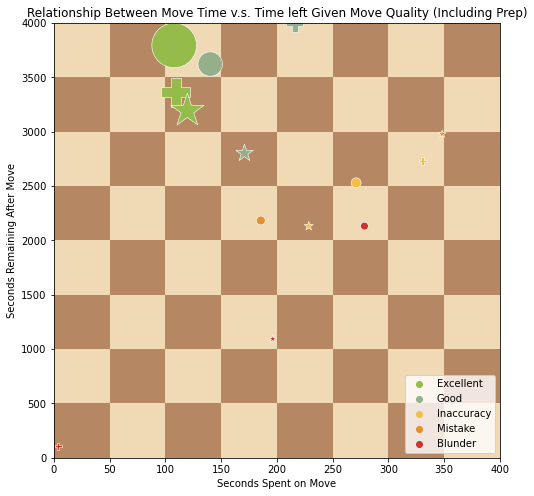

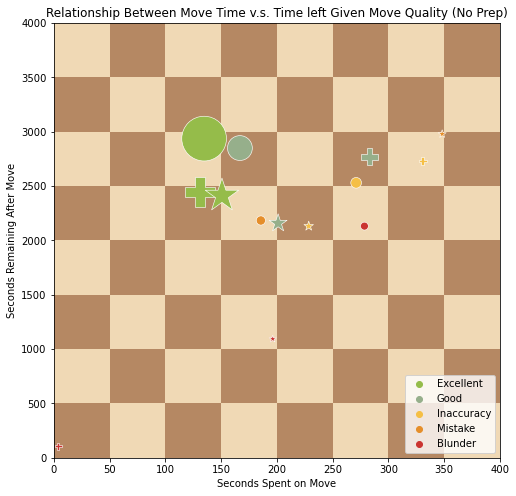

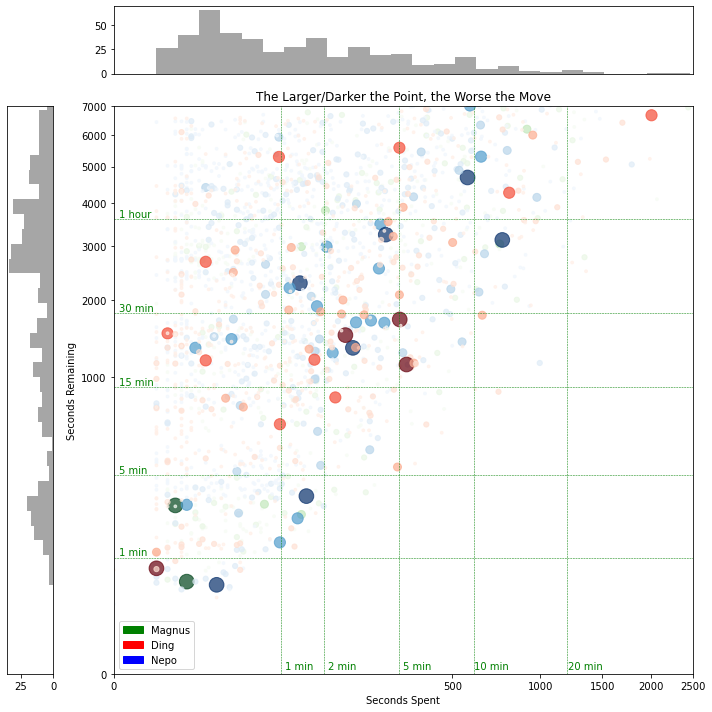

In [17]:
plot_chessboard_vis(merge_players_data(final_vis_prep_or_not(True)),title = 'Including Prep')
plot_chessboard_vis(merge_players_data(final_vis_prep_or_not(False)))

plot_move_time_time_remaining()

# 5 Discussion

Clearly, the strength of each chess move seem to be correlated (in varying degrees of strength for different players) with time, whether it is the amount of time the players spent before each decision, or how much time they have remaining.

If we look at the first two chessboard-themed scatterplots, it seems like, regardless of we consider prep or not, the time_remaining and time_spent on move seems to be in a similar region for a given classification across players. However, mistakes and blunders may suffer from being too limited in sample size, therefore their locations don't seem to be as concentrated as the case for 'excellent', 'good', or 'inaccurate' moves.

The third visualization, a scatterplot with modified x and y axes, shows all the moves by each player based on how long each move took and how much time the players still had remaining at the time of the move. The bins of histograms are also transformed by the same function that oversaw the transformation of the axes in the scatterplot. From the side_histogram, we can see that seconds_remaining seems to be bimodal with a cluster that should probably be explored in depth at 2500 seconds (perhaps a result of reaching the second time-control faciliates this unnatural jump), with a concentration of moves around 0~7 minutes, which is probably consisting of some long endgame grind or rapid time-control tiebreaks. As for the histogram on top that depicts the length of players' think before making their move, it seems to follow the classic log-normal distribution.

Let's have a look at Magnus Carlsen's moves, which are the 'crosses' (+) in the chessboard-themed visual, inspired by his Norweigan roots, and the green points in the scatterplot. His play is the gold standard of modern chess, having reigned as the World Champion and the highest rated player for ten consecutive years. Throughout his 11-game duel with Nepo in 2021, he made 2 bad moves (out of 568), which in fact occurred in the same game less than ten mvoes apart. In the chessboard-themed scatterplot, we can see the tiny red cross near the origin, and in the scatterplot with histograms, there are two big green dots in the bottom left. Blunders made in such conditions are what we call forced-errors, as opposed to unforced, where the player simply does not have enough time to work out the complexities of the position given the constraints of his ticking clock. Another interesting aspect of Magnus's game is that, if we compare the location of the green and grey markers between the chessboard-themed scatterplots (their only difference being the inclusion or exclusion or preparation moves), we uncover another interesting behavior, exemplified by the downward-right shift of the best moves being consistent across three players, and the same shift consistent across good move for Ding and Nepo, but not Magnus. Magnus has a lot less "best moves" in his prep, presumably to steer the game into unknown territories early and therefore deviating early with suboptimal options. Finally, consider the 'crosses' in the chess-themed scatterplot (No-Prep). Magnus did not make unforced errors throughout his match, but he is still human, and it is impossible to alwayas navigate the entire game perfectly. Sometimes, when the position is complex, even hard and deliberate thinks may fail to enlighten the player with the best move in a position, and from the scatterplot, we can see that, in terms of seconds spent on move, the green (excellent), gray (good), and yellow (inaccurate) moves are aligned, likely correlated by the difficulty of the position, the more difficult, the longer one must think, and the likelier it is to make a slight mistake. Magnus's move quality distribution in the 2021 World Championship is the pinnacle that players strive for, a horizontal line going right in the order of excellent, good, and inaccurate, while mistakes and blunders only happen in desperate time troubles.

Taking a look at the third scatterplot, the red points (Ding) seems to scatter all over the place. Let's focus on the three darkest red-dots near the center of the graph, where Ding spent 5 minutes before making his move when his clock still had 20-30 minutes. He was really nervous playing such a high stakes match, and you could already consider him to be in time trouble, since unlike Magnus's blunders, which happend when he had nearly no time and had to make a few moves very quickly, Ding possibly still had 20-30 minutes to make around 15 moves in some cases, so he really wasn't able to think for any longer. I wouldn't call such blunders unforced, although working on discipline with his clock certainly would help his results. Nepo, on the other hand, has a reputation of playing quickly and applying a lot of pressure to his opponent's clock, but sometimes his quick play backfires and it turns out that his intuition betrayed him and his move was flawed. It does seem like he makes more mistakes even with a lot of time on their clock, but it's probably better to increase our sample size before drawing any concrete conclusions. Finally, aside from seconds spent on move and seconds remaining, I imagine the variable moves_to_time_control may also be an important predictor, since if it is high, then the time trouble phase starts earlier than when it is low, and players generally make much more mistakes in time trouble.

In conclusion, the quality of chess moves are influenced by a variety of factors. Individually looking at each variable, you could say time spent on move and move quality is negatively correlated (complex positions bleed time and breed mistakes), while time remaining and move quality is positively correlated (the game complicates as time goes on). However, together, they suggest that if a player is in time trouble (his moves will have the attribute low time spent and low time remaining), his move quality is likely to take a hit.